# Import necessary libraries

In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier , XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
import joblib

import sys
import os

# Add the parent directory's 'scripts' folder to the Python path
sys.path.append(os.path.abspath('../scripts'))

# Import the function
from class_metrics import display_metrics

# Load the the users with segments dataset

In [2]:
df_init = pd.read_csv('../data/cleaned/users_usage_segmented.csv')

In [3]:
sorted(df_init.columns)

['avg_data_after_upgrade',
 'avg_data_before_upgrade',
 'days_active_after',
 'increased_usage',
 'recharge_growth',
 'std_after',
 'std_before',
 'time_to_first_data_use',
 'total_recharge_after',
 'total_recharge_before',
 'user',
 'user_segment']

### we need to drop the columns that are not needed for the analysis

> 'avg_data_after_upgrade','days_active_after','std_after','time_to_first_data_use','user_segment', 'total_recharge_after',

so we only need the following columns

> 'avg_data_before_upgrade','increased_usage'(our target),'std_before','total_recharge_before','user',

In [4]:
df =  df_init[['user', 'avg_data_before_upgrade', 'std_before', 'total_recharge_before', 'increased_usage']]
df.sample(10)

,user,avg_data_before_upgrade,std_before,total_recharge_before,increased_usage
8548,225798742964,NaN,NaN,NaN,0
17778,225798788647,NaN,NaN,NaN,0
5303,225798726787,3332683.720,NaN,517.100000,0
7658,225798738616,729002.955,585957.066208,384.528261,0
13215,225798766188,NaN,NaN,NaN,0
16845,225798784058,NaN,NaN,NaN,0
19028,225798794890,315849.610,456236.896322,762.478261,0
13062,225798765474,NaN,NaN,NaN,0
14382,225798772120,NaN,NaN,NaN,0
3715,225798718931,NaN,NaN,NaN,0


Logistic, RandomForest or any other tree-based model from sklearn library don't support nan values and we have them

In [5]:
df.isna().sum()

user                           0
avg_data_before_upgrade    10229
std_before                 14441
total_recharge_before      10229
increased_usage                0
dtype: int64

### Handle Missing values

we have missing values in 3 columns, we can't impute them bcs we might introduce false informations about users. 

**Solution:**

For each column with missing values let's create a binary label/flag indicating whether it's missing or not, then after let's fill nan with 0 which indicates we don't have values for that column

In [6]:
df = df.copy()
df['data_flag'] = df['avg_data_before_upgrade'].isna().astype(int)
df['std_flag'] = df['std_before'].isna().astype(int)
df['recharge_flag'] = df['total_recharge_before'].isna().astype(int)

# Fill missing values with 0

df['avg_data_before_upgrade'] = df['avg_data_before_upgrade'].fillna(0)
df['std_before'] = df['std_before'].fillna(0)
df['total_recharge_before'] = df['total_recharge_before'].fillna(0)

df.isna().sum()


user                       0
avg_data_before_upgrade    0
std_before                 0
total_recharge_before      0
increased_usage            0
data_flag                  0
std_flag                   0
recharge_flag              0
dtype: int64

In [7]:
df.to_csv('../data/cleaned/users_segmented_zero_nan.csv', index=False) 

# Train & Test split

In [8]:
X = df.drop(columns=['user', 'increased_usage'])
y = df['increased_usage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 ,shuffle=True)
X_train.shape

(16033, 6)

# Baseline Model : RandomForest Classifier

Let's train & predict using a RandomForest regressor

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_scores = rf.predict_proba(X_test)[:, 1]

overfitness check

In [10]:
y_train_pred = rf.predict(X_train)
y_train_score = rf.predict_proba(X_train)[:, 1]

#### Baseline Metrics of the RandomForest model

In [11]:
print('************************Test metrics***********************')
display_metrics(y_true=y_test, y_pred=y_pred, y_scores=y_scores)

print('************************Train metrics***********************')
display_metrics(y_true=y_train, y_pred=y_train_pred , y_scores=y_train_score)

print('************************Feature importance***********************')
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

************************Test metrics***********************
Classification Metrics:
Precision: 0.8707
AUC-ROC: 0.9807
************************Train metrics***********************
Classification Metrics:
Precision: 1.0000
AUC-ROC: 1.0000
************************Feature importance***********************


,Feature,Importance
0,avg_data_before_upgrade,0.529239
3,data_flag,0.134300
2,total_recharge_before,0.133181
5,recharge_flag,0.106546
1,std_before,0.095049
4,std_flag,0.001685


# XGBoost models : training & predicting

## Increased usage predictions

In [12]:
# new_info = df

increased_usage_model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.3,
    random_state=42,
    tree_method='hist',
    enable_categorical=True,
)

increased_usage_model.fit(X_train, y_train)

y_pred_xgb = increased_usage_model.predict(X_test)
y_scores_xgb = increased_usage_model.predict_proba(X_test)[:, 1]

y_train_pred_xgb = increased_usage_model.predict(X_train)
y_train_score_xgb = increased_usage_model.predict_proba(X_train)[:, 1]

print('************************Test metrics***********************')
display_metrics(y_true=y_test, y_pred=y_pred_xgb, y_scores=y_scores_xgb)

print('************************Train metrics***********************')
display_metrics(y_true=y_train, y_pred=y_train_pred_xgb, y_scores=y_train_score_xgb)

print('************************Feature importance***********************')
importances_xgb = increased_usage_model.feature_importances_
feature_names_xgb = X_train.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names_xgb, 'Importance': importances_xgb})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)
feature_importance_df_xgb

************************Test metrics***********************
Classification Metrics:
Precision: 0.8551
AUC-ROC: 0.9800
************************Train metrics***********************
Classification Metrics:
Precision: 0.9444
AUC-ROC: 0.9975
************************Feature importance***********************


,Feature,Importance
3,data_flag,0.841438
0,avg_data_before_upgrade,0.123592
4,std_flag,0.015442
1,std_before,0.011292
2,total_recharge_before,0.008236
5,recharge_flag,0.000000


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

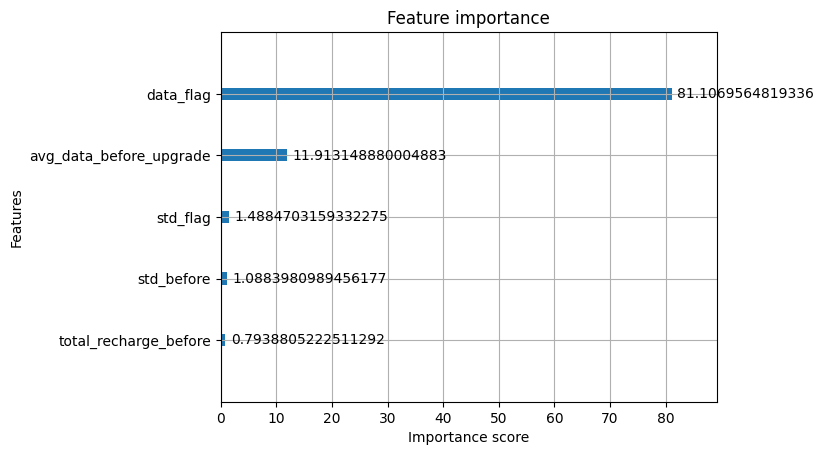

In [13]:
xgb.plot_importance(importance_type='gain', booster=increased_usage_model)

In [14]:
X_all = pd.concat([X_train, X_test])
probs_all = np.concatenate((y_train_score_xgb, y_scores_xgb))

X_all['upgrade_prob_confidence'] = np.round(probs_all, 2)

X_all = X_all.sort_index()
df = df.sort_index()
df['upgrade_prob_confidence'] = np.round(X_all['upgrade_prob_confidence'], 2)
df

,user,avg_data_before_upgrade,std_before,total_recharge_before,increased_usage,data_flag,std_flag,recharge_flag,upgrade_prob_confidence
0,225798700001,156802.990,0.000000e+00,113.47,1,0,1,0,0.95
1,225798700012,88923.625,1.257570e+05,124.37,1,0,0,0,0.96
2,225798700014,0.000,0.000000e+00,0.00,0,1,1,1,0.00
3,225798700016,152250.540,1.410422e+05,1885.47,1,0,0,0,1.00
4,225798700032,0.000,0.000000e+00,0.00,0,1,1,1,0.00
...,...,...,...,...,...,...,...,...,...
20037,225798799970,0.000,0.000000e+00,0.00,0,1,1,1,0.00
20038,225798799973,0.000,0.000000e+00,0.00,0,1,1,1,0.00
20039,225798799975,0.000,0.000000e+00,0.00,0,1,1,1,0.00
20040,225798799979,1173618.430,1.912685e+06,695.60,0,0,0,0,0.00


In [15]:
df_init

,user,avg_data_before_upgrade,std_before,total_recharge_before,avg_data_after_upgrade,std_after,total_recharge_after,days_active_after,time_to_first_data_use,recharge_growth,increased_usage,user_segment
0,225798700001,156802.990,NaN,113.47,406223.960000,6.458136e+05,7574.878261,27,0.0,7461.408261,1,medium
1,225798700012,88923.625,1.257570e+05,124.37,471228.741111,6.124226e+05,14863.328261,53,0.0,14738.958261,1,medium
2,225798700014,NaN,NaN,NaN,669976.774043,1.080963e+06,15855.988261,45,0.0,NaN,0,high
3,225798700016,152250.540,1.410422e+05,1885.47,783516.914167,1.818749e+06,8418.270000,23,0.0,6532.800000,1,high
4,225798700032,NaN,NaN,NaN,458873.072281,5.792486e+05,10687.680000,56,0.0,NaN,0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
20037,225798799970,NaN,NaN,NaN,482788.041754,5.581332e+05,22801.180000,53,0.0,NaN,0,medium
20038,225798799973,NaN,NaN,NaN,590683.082712,8.320416e+05,22487.620000,54,0.0,NaN,0,high
20039,225798799975,NaN,NaN,NaN,546710.570682,1.131976e+06,13216.378261,41,0.0,NaN,0,medium
20040,225798799979,1173618.430,1.912685e+06,695.60,458191.267143,5.487318e+05,5562.990000,13,0.0,4867.390000,0,medium


## user_segment predictions

In [16]:
X_X = df.drop(columns=['user'])

y_y = df_init['user_segment'].map({
        'non': 0,
        'low': 1,
        'medium': 2,
        'high': 3
    })

X_X_train, X_X_test, y_y_train, y_y_test = train_test_split(X_X, y_y, test_size=0.2, random_state=42 ,shuffle=True)

user_segment_model = XGBClassifier(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.05,
    random_state=42,
    tree_method='hist',
    enable_categorical=True
)

user_segment_model.fit(X_X_train, y_y_train)

y_pred_user_segment = user_segment_model.predict(X_X_test)
proba = user_segment_model.predict_proba(X_X_test)

# Get the probability of the predicted class for each sample
y_scores_user_segment = proba[np.arange(len(y_pred_user_segment)), y_pred_user_segment]

y_train_pred_user_segment = user_segment_model.predict(X_X_train)
proba1 = user_segment_model.predict_proba(X_X_train)

# Get the probability of the predicted class for each sample
y_train_score_user_segment = proba1[np.arange(len(y_train_pred_user_segment)), y_train_pred_user_segment]


************************Test metrics***********************
Multi Classification Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.44      0.58       106
           1       0.38      0.06      0.11       900
           2       0.51      0.93      0.66      1984
           3       0.46      0.08      0.14      1019

    accuracy                           0.51      4009
   macro avg       0.55      0.38      0.37      4009
weighted avg       0.48      0.51      0.40      4009

Confusion Matrix:


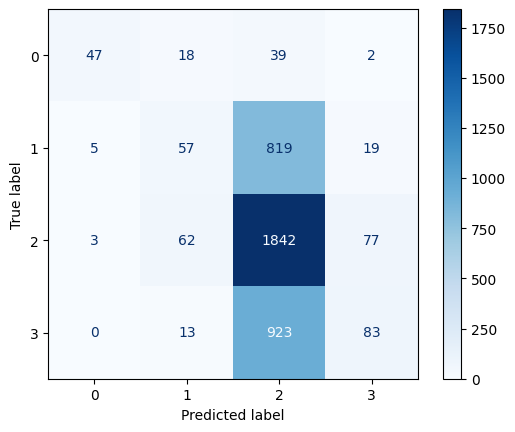

************************Train metrics***********************
Multi Classification Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78       402
           1       0.87      0.15      0.25      3603
           2       0.56      0.99      0.71      8036
           3       0.89      0.21      0.34      3992

    accuracy                           0.60     16033
   macro avg       0.82      0.50      0.52     16033
weighted avg       0.72      0.60      0.52     16033

Confusion Matrix:


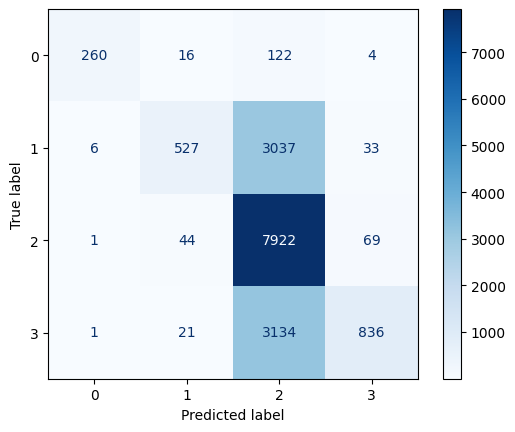

************************Feature importance***********************


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

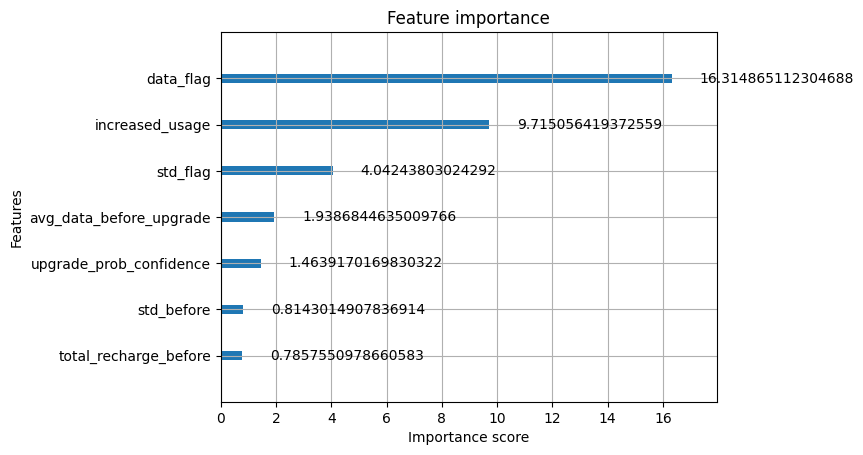

In [17]:
print('************************Test metrics***********************')
display_metrics(y_true=y_y_test, y_pred=y_pred_user_segment, y_scores=y_scores_user_segment , mode='multi')
print('************************Train metrics***********************')
display_metrics(y_true=y_y_train, y_pred=y_train_pred_user_segment, y_scores=y_train_score_user_segment, mode='multi')
print('************************Feature importance***********************')
importances_user_segment = user_segment_model.feature_importances_
feature_names_user_segment = X_X.columns
feature_importance_df_user_segment = pd.DataFrame({'Feature': feature_names_user_segment, 'Importance': importances_user_segment})
feature_importance_df_user_segment = feature_importance_df_user_segment.sort_values(by='Importance', ascending=False)
feature_importance_df_user_segment
xgb.plot_importance(importance_type='gain', booster=user_segment_model)

In [18]:
X_X_all = pd.concat([X_X_train, X_X_test])

user_segments = np.concatenate((y_train_pred_user_segment,y_pred_user_segment)) 

X_X_all['user_segment'] = user_segments

X_X_all['user_segment'] = X_X_all['user_segment'].replace({
    0: 'non',
    1: 'low',
    2: 'medium',
    3: 'high'
})
X_X_all['user_segment'] = X_X_all['user_segment'].astype(str)

probs_all_user_segment = np.concatenate((y_train_score_user_segment, y_scores_user_segment))

X_X_all['user_segment_prob_confidence'] = np.round(probs_all_user_segment, 2)

X_X_all = X_X_all.sort_index()
df = df.sort_index()

df['user_segment'] = X_X_all['user_segment']

df['user_segment_prob_confidence'] = np.round(X_X_all['user_segment_prob_confidence'], 2)

In [19]:
df

,user,avg_data_before_upgrade,std_before,total_recharge_before,increased_usage,data_flag,std_flag,recharge_flag,upgrade_prob_confidence,user_segment,user_segment_prob_confidence
0,225798700001,156802.990,0.000000e+00,113.47,1,0,1,0,0.95,medium,0.48
1,225798700012,88923.625,1.257570e+05,124.37,1,0,0,0,0.96,medium,0.55
2,225798700014,0.000,0.000000e+00,0.00,0,1,1,1,0.00,medium,0.50
3,225798700016,152250.540,1.410422e+05,1885.47,1,0,0,0,1.00,medium,0.46
4,225798700032,0.000,0.000000e+00,0.00,0,1,1,1,0.00,medium,0.50
...,...,...,...,...,...,...,...,...,...,...,...
20037,225798799970,0.000,0.000000e+00,0.00,0,1,1,1,0.00,medium,0.50
20038,225798799973,0.000,0.000000e+00,0.00,0,1,1,1,0.00,medium,0.50
20039,225798799975,0.000,0.000000e+00,0.00,0,1,1,1,0.00,medium,0.50
20040,225798799979,1173618.430,1.912685e+06,695.60,0,0,0,0,0.00,medium,0.50


In [20]:
df_init

,user,avg_data_before_upgrade,std_before,total_recharge_before,avg_data_after_upgrade,std_after,total_recharge_after,days_active_after,time_to_first_data_use,recharge_growth,increased_usage,user_segment
0,225798700001,156802.990,NaN,113.47,406223.960000,6.458136e+05,7574.878261,27,0.0,7461.408261,1,medium
1,225798700012,88923.625,1.257570e+05,124.37,471228.741111,6.124226e+05,14863.328261,53,0.0,14738.958261,1,medium
2,225798700014,NaN,NaN,NaN,669976.774043,1.080963e+06,15855.988261,45,0.0,NaN,0,high
3,225798700016,152250.540,1.410422e+05,1885.47,783516.914167,1.818749e+06,8418.270000,23,0.0,6532.800000,1,high
4,225798700032,NaN,NaN,NaN,458873.072281,5.792486e+05,10687.680000,56,0.0,NaN,0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
20037,225798799970,NaN,NaN,NaN,482788.041754,5.581332e+05,22801.180000,53,0.0,NaN,0,medium
20038,225798799973,NaN,NaN,NaN,590683.082712,8.320416e+05,22487.620000,54,0.0,NaN,0,high
20039,225798799975,NaN,NaN,NaN,546710.570682,1.131976e+06,13216.378261,41,0.0,NaN,0,medium
20040,225798799979,1173618.430,1.912685e+06,695.60,458191.267143,5.487318e+05,5562.990000,13,0.0,4867.390000,0,medium


## Avg_data_after_upgrade predictions

In [21]:
XX = df.drop(columns=['user'])
XX['user_segment'] = df_init['user_segment'].astype('category')
yy = df_init['avg_data_after_upgrade'] 

XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.2, random_state=42 ,shuffle=True)

avg_data_estimator = XGBRegressor(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.08,
    random_state=42,
    tree_method='hist',
    enable_categorical=True,
)

avg_data_estimator.fit(XX_train, yy_train)

yy_pred = avg_data_estimator.predict(XX_test)

yy_train_pred = avg_data_estimator.predict(XX_train)



In [22]:
print('************************Test metrics***********************')
display_metrics(y_true=yy_test, y_pred=yy_pred, mode='regr')

print('************************Train metrics***********************')
display_metrics(y_true=yy_train, y_pred=yy_train_pred, mode='regr')

print('************************Feature importance***********************')
importances_xx = avg_data_estimator.feature_importances_
feature_names_xx = XX.columns
feature_importance_df_xx = pd.DataFrame({'Feature': feature_names_xx, 'Importance': importances_xx})
feature_importance_df_xx = feature_importance_df_xx.sort_values(by='Importance', ascending=False)
feature_importance_df_xx

************************Test metrics***********************
Regression Metrics:
Mae : 61959.5009
R2_Score: 0.7664
************************Train metrics***********************
Regression Metrics:
Mae : 51853.4103
R2_Score: 0.8249
************************Feature importance***********************


,Feature,Importance
8,user_segment,0.966347
0,avg_data_before_upgrade,0.007907
9,user_segment_prob_confidence,0.005592
7,upgrade_prob_confidence,0.004459
5,std_flag,0.004233
3,increased_usage,0.004014
2,total_recharge_before,0.003754
1,std_before,0.003694
4,data_flag,0.000000
6,recharge_flag,0.000000


## recharge growth predictions

In [23]:
df_init['user_segment'].value_counts()

user_segment
medium    10020
high       5011
low        4503
non         508
Name: count, dtype: int64

In [24]:
feautures_to_use  = [
    'avg_data_after_upgrade',
    'avg_data_before_upgrade',
    'increased_usage',
    'recharge_growth',
    'std_before',
    'total_recharge_before',
    'user',
    'user_segment'
    ]

XXX = df_init[feautures_to_use].drop(columns=['recharge_growth','user'])
yyy = df_init['recharge_growth']


yyy = yyy.fillna(0)

XXX['user_segment'] = XXX['user_segment'].astype('category')

XXX_train, XXX_test, yyy_train, yyy_test = train_test_split(XXX, yyy, test_size=0.2, random_state=42 ,shuffle=True)

recharge_growth_estimator = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.3,
    random_state=42,
    tree_method='hist',
    enable_categorical=True,
)

recharge_growth_estimator.fit(XXX_train, yyy_train)

yyy_pred = recharge_growth_estimator.predict(XXX_test)

yyy_train_pred = recharge_growth_estimator.predict(XXX_train)


In [25]:
print('************************Test metrics***********************')
display_metrics(y_true=yyy_test, y_pred=yyy_pred, mode='regr')

print('************************Train metrics***********************')
display_metrics(y_true=yyy_train, y_pred=yyy_train_pred, mode='regr')

print('************************Feature importance***********************')
importances_xxx = recharge_growth_estimator.feature_importances_
feature_names_xxx = XXX.columns
feature_importance_df_xxx = pd.DataFrame({'Feature': feature_names_xxx, 'Importance': importances_xxx})
feature_importance_df_xxx = feature_importance_df_xxx.sort_values(by='Importance', ascending=False)
feature_importance_df_xxx

************************Test metrics***********************
Regression Metrics:
Mae : 2432.0533
R2_Score: 0.6108
************************Train metrics***********************
Regression Metrics:
Mae : 1375.2450
R2_Score: 0.8703
************************Feature importance***********************


,Feature,Importance
1,avg_data_before_upgrade,0.366795
4,total_recharge_before,0.344123
5,user_segment,0.117895
0,avg_data_after_upgrade,0.063469
2,increased_usage,0.061741
3,std_before,0.045977


# Save the models

In [26]:
joblib.dump(increased_usage_model, '../output/models/increased_usage_xgb.pkl')
joblib.dump(avg_data_estimator, '../output/models/avg_data_xgb.pkl')
joblib.dump(recharge_growth_estimator, '../output/models/recharge_growth_xgb.pkl')
joblib.dump(user_segment_model, '../output/models/user_segment_xgb.pkl')

['../output/models/user_segment_xgb.pkl']

# Report

read the final report notebook found in the report directory